# Определение стоимости автомобилей с пробегом

**Описание проекта:**

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Заказчик предоставил датасет с историческими данными: технические характеристики, комплектации и цены автомобилей. 
***
**Цель проекта:** 

Построить модель для определения стоимости автомобилей.
***
**Особенности:**

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.
***

# Загрузка библиотек

In [1]:
!pip install --upgrade scikit-learn
!pip install --upgrade phik
!pip install --upgrade lightgbm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from lightgbm import LGBMRegressor
from phik.report import plot_correlation_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV

Глобальные переменные

In [2]:
RANDOM_STATE = 42

## Подготовка данных

**Загрузка датасета**

In [3]:
df = pd.read_csv('/datasets/autos.csv')

**Проверка соответствия данных описанию**

In [4]:
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50



Некоторые признаки имеют неверный формат:
- Признаки DateCrawled, DateCreated, LastSeen должны иметь тип datetime;
- В наименованиях столюцов имеются заглавные буквы;
- В остальном данные соответствуют описанию.

Напишем функцию по преобразованию столбцов в формат даты-времени

In [5]:
def to_dt(cols):
    '''Функция преобразует столбцы датасета в формат даты-времени'''
    for col in cols:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%dT%H:%M:%S')

**Исправление формата столбцов**

In [6]:
to_dt(['DateCrawled', 'DateCreated', 'LastSeen'])

Проверка изменений

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Форматы данных успешно изменены

**Правка наименований столбцов**

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df = df.rename(columns={'datecrawled': 'date_crawled', 'vehicletype': 'vehicle_type', 'registrationyear': 'registration_year',
                  'registrationmonth': 'registration_month', 'fueltype': 'fuel_type', 'datecreated': 'date_created', 
                  'numberofpictures': 'number_of_pictures', 'postalcode': 'postal_code', 'lastseen': 'last_seen'});

Проверка изменений

In [10]:
df.columns.tolist()

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'repaired',
 'date_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']

Правки наименований столбцов успешно применены

**Обработка пропусков**

Некоторые признаки имеют пропуски. Скорее всего владельцы сами не заполнили эти данные в анкете т.к. пропусков много в небольшом количестве столбцов. Возможно это связано с формой ввода данных, поля которой оказались не обязательными.

Пропущенные значения признаков vehicle_type и model можно заполнить значением unnamed, чтобы они не повлияли на результаты обучения моделей.

In [11]:
df['vehicle_type'] = df['vehicle_type'].fillna('unnamed')
df['model'] = df['model'].fillna('unnamed')

Пропуски в столбцах gearbox и fuel_type можно заполнить модой. Пропущенные значения в признаке repaired можно заполнить значением 'no', так как с большей вероятностью владельцы не заполняли данные, потому что машина не была в ремонте 

In [12]:
df['gearbox'] = df['gearbox'].fillna(value=df['gearbox'].mode()[0]);
df['fuel_type'] = df['fuel_type'].fillna(value=df['fuel_type'].mode()[0]);
df['repaired'] = df['repaired'].fillna('no')

Проверка изменений

In [13]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

**Обработка дубликатов**

Поиск дубликатов с учетом пропусков

In [14]:
dubl = df[df.drop(['vehicle_type', 'fuel_type', 'gearbox'], axis=1).duplicated() == True]
print(f'Всего найдено и удалено {dubl.count()[0]} дубликатов.')

Всего найдено и удалено 7 дубликатов.


Удаление дубликатов

In [15]:
df = df.query("index not in @dubl.index.tolist()").reset_index(drop=True)

Проверка изменений

In [16]:
df.duplicated().sum()

0

Дубликаты успешно удалены

**Удаление неявных дубликатов**

Определение уникальных значений признаков

In [17]:
for col in df.columns:
    display(col)
    display(df[col].sort_values().unique())

'date_crawled'

array(['2016-03-05T14:06:22.000000000', '2016-03-05T14:06:23.000000000',
       '2016-03-05T14:06:24.000000000', ...,
       '2016-04-07T14:36:55.000000000', '2016-04-07T14:36:56.000000000',
       '2016-04-07T14:36:58.000000000'], dtype='datetime64[ns]')

'price'

array([    0,     1,     2, ..., 19998, 19999, 20000])

'vehicle_type'

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'unnamed', 'wagon'], dtype=object)

'registration_year'

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

'gearbox'

array(['auto', 'manual'], dtype=object)

'power'

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

'model'

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

'kilometer'

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000])

'registration_month'

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

'fuel_type'

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol'],
      dtype=object)

'brand'

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

'repaired'

array(['no', 'yes'], dtype=object)

'date_created'

array(['2014-03-10T00:00:00.000000000', '2015-03-20T00:00:00.000000000',
       '2015-06-18T00:00:00.000000000', '2015-08-07T00:00:00.000000000',
       '2015-08-10T00:00:00.000000000', '2015-09-04T00:00:00.000000000',
       '2015-09-09T00:00:00.000000000', '2015-11-02T00:00:00.000000000',
       '2015-11-08T00:00:00.000000000', '2015-11-10T00:00:00.000000000',
       '2015-11-12T00:00:00.000000000', '2015-11-17T00:00:00.000000000',
       '2015-11-23T00:00:00.000000000', '2015-11-24T00:00:00.000000000',
       '2015-12-05T00:00:00.000000000', '2015-12-06T00:00:00.000000000',
       '2015-12-17T00:00:00.000000000', '2015-12-27T00:00:00.000000000',
       '2015-12-30T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', '2016-01-06T00:00:00.000000000',
       '2016-01-07T00:00:00.000000000', '2016-01-08T00:00:00.000000000',
       '2016-01-10T00:00:00.000000000', '2016-01-13T00:00:00.000000000',
       '2016-01-15T00:00:00.000000000', '2016-01-16

'number_of_pictures'

array([0])

'postal_code'

array([ 1067,  1068,  1069, ..., 99994, 99996, 99998])

'last_seen'

array(['2016-03-05T14:15:08.000000000', '2016-03-05T14:15:16.000000000',
       '2016-03-05T14:15:39.000000000', ...,
       '2016-04-07T14:58:49.000000000', '2016-04-07T14:58:50.000000000',
       '2016-04-07T14:58:51.000000000'], dtype='datetime64[ns]')

Имеются неявные дубликаты в признаке fuel_type. Исправление

In [18]:
df['fuel_type'] = df['fuel_type'].str.replace('petrol', 'gasoline')

**Проверка изменений**

In [19]:
display(df['fuel_type'].unique().tolist())

['gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric']

Имеются аномально низкие значения в признаке price. Удалим эти значения. Установим планку в 1000 евро.

In [20]:
df = df.query('price > 1000')

**Удаление неинформативных признаков**

Признаки 'date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen' не имеют отношение к характеристикам автомобиля и не имеют потенциального влияния на цену. Их необходимо удалить.

In [21]:
df = df.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

Проверка изменений

In [22]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

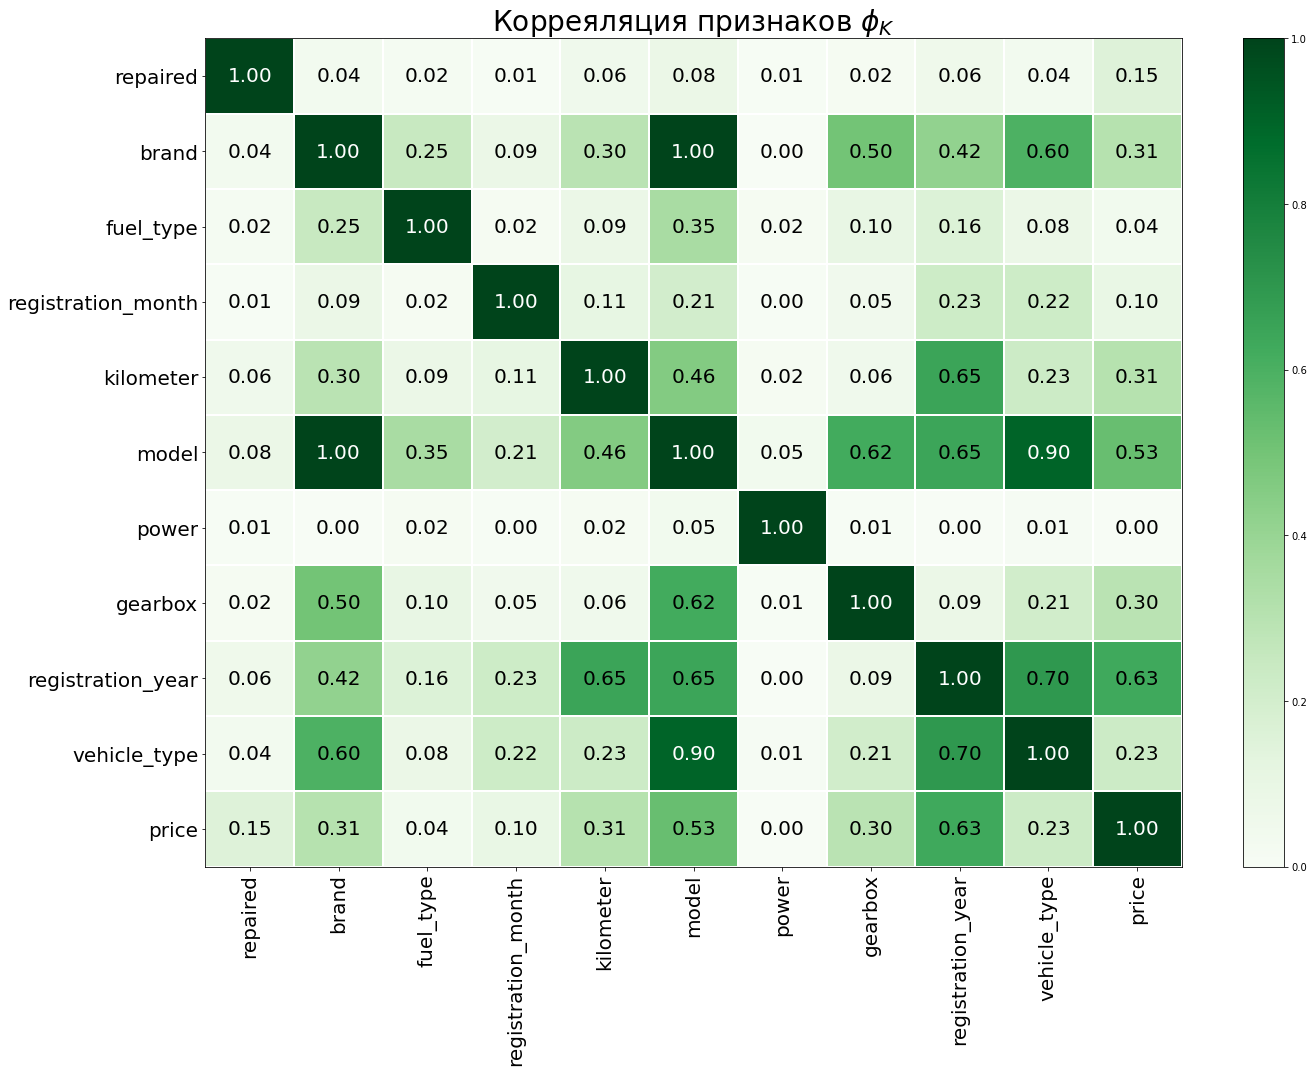

In [23]:
overview = df.phik_matrix(interval_cols=['price', 'power']);

plot_correlation_matrix(
    overview.values,
    x_labels=overview.columns,
    y_labels=overview.index,
    vmin=0,
    vmax=1,
    color_map='Greens',
    title=r'Корреяляция признаков $\phi_K$',
    fontsize_factor=2,
    figsize=(20, 15)
)

Удаление признаков, если они слабо коррелируют с целевым признаком. Зададим значение корреляции 0.2

In [24]:
to_drop = overview[overview['price'] < 0.2]['price'].index.tolist()
df = df.drop(to_drop, axis=1)
if len(to_drop) == 0:
    print(f'Все признаки достаточно значимые')
else:
    print(f'Удалено {len(to_drop)} признаков: {to_drop}')

Удалено 4 признаков: ['power', 'registration_month', 'fuel_type', 'repaired']


Проверка изменений

In [25]:
df.columns.tolist()

['price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'model',
 'kilometer',
 'brand']

Удаление неинформативных признаков успешно.

**Разделение признаков на типы**

In [26]:
discret = []
for name in df.select_dtypes(include="int").columns.tolist():
    if len(df[name].unique()) <= 10:
        discret.append(name)
col = df.drop(discret, axis=1).select_dtypes(include='number').columns.tolist()[1:]
cat = df.select_dtypes(exclude='number').columns.tolist()
print(f'Количественных признаков: {col}')
print(f'Категориальных признаков: {cat}')
print(f'Дискретных признаков: {discret}')

Количественных признаков: ['registration_year', 'kilometer']
Категориальных признаков: ['vehicle_type', 'gearbox', 'model', 'brand']
Дискретных признаков: []


**Автоматизация построения графиков**

In [27]:
plt.rc('font', size=12)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

def plot_box(col_names):
    '''Функция строит диаграммы размаха и распределения количественных признаков. Принимает на вход список столбцов.'''
    if len(col_names) > 1:
        fig, axes = plt.subplots(nrows=len(col_names), ncols=2, figsize=(15, 15))  
        plt.subplots_adjust(wspace=0.2, hspace=0.2)
        plt.figure(figsize=(15, 10))
        for num, name in enumerate(col_names):
            df[name].plot(kind='box',
                           title=f'Диаграмма размаха\nпризнака: {name}',
                           ax=axes[num, 0],
                           xlabel='',
                           ylabel=''
                          )
            df[name].plot(kind='hist',
                           bins=30, 
                           ax=axes[num, 1],
                           title=f'Диаграмма распределения\nпризнака: {name}',
                           xlabel='',
                           ylabel='Частота'
                          )
    else:
        fig, axes = plt.subplots(nrows=len(col_names), ncols=2, figsize=(15, 10)) 
        plt.figure(figsize=(10, 10))
        df[col_names].plot(kind='box',
               title=f'Диаграмма размаха\nпризнака: {col_names}',
               ax=axes[0],
               xlabel='',
               ylabel=''
              );
        df[col_names].plot(kind='hist',
               bins=30, 
               ax=axes[1],
               title=f'Диаграмма распределения\nпризнака: {col_names}',
               xlabel='',
               ylabel='Частота'
              );
    plt.show();

def plot_bar(col_names, ylabel=''):
    '''Функция строит столбчатые диаграммы распределения категориальных и дискретных признаков. Принимает на вход список столбцов.'''
#    fig, axes = plt.subplots(nrows=2, ncols=int(len(col_names)/2), figsize=(20, 10))
#    plt.subplots_adjust(wspace=0.7, hspace=0.5)
    for name in col_names:
        plt.figure(figsize=(10, len(df[name].unique())*0.5))
        sns.countplot(
            data=df,
            y=name,
        ).set(title=f'Распределение:\n{name}', xlabel='Количество', ylabel=ylabel)
        plt.show()

def plot_pie(col_names):
    '''Функция строит круговые диаграммы распределения категориальных признаков. Принимает на вход список столбцов.'''
    fig, axes = plt.subplots(nrows=2, ncols=int(len(col_names)/2), figsize=(20, 15))    
    plt.subplots_adjust(wspace=0.2)
    for num, name in enumerate(col_names):
        row =  0 if num < 2 else 1
        num = num%2
        (df.groupby(name)[name].count() / df[name].count()).sort_values(ascending=False).plot(
            kind='pie', 
            ax=axes[num, row], 
            title=f'Соотношение:\n{name}',
            autopct='%1.1f%%',
            startangle=90,
            ylabel=''
        )
    plt.show()

'Количественные признаки:'

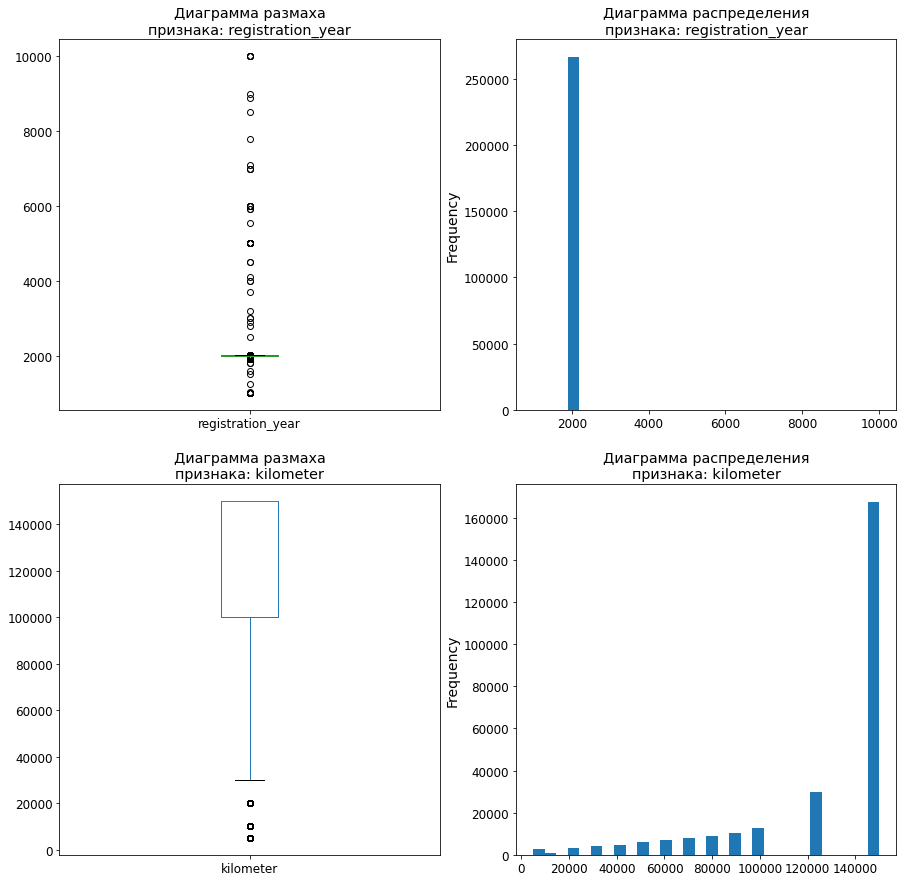

<Figure size 1080x720 with 0 Axes>

In [28]:
display('Количественные признаки:')
plot_box(col)

'Категориальные признаки'

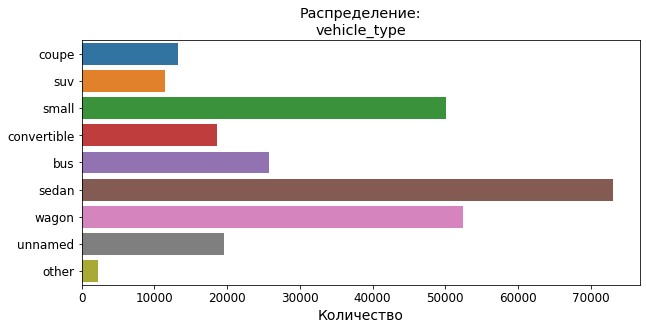

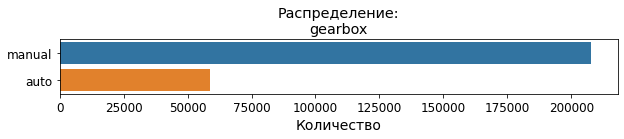

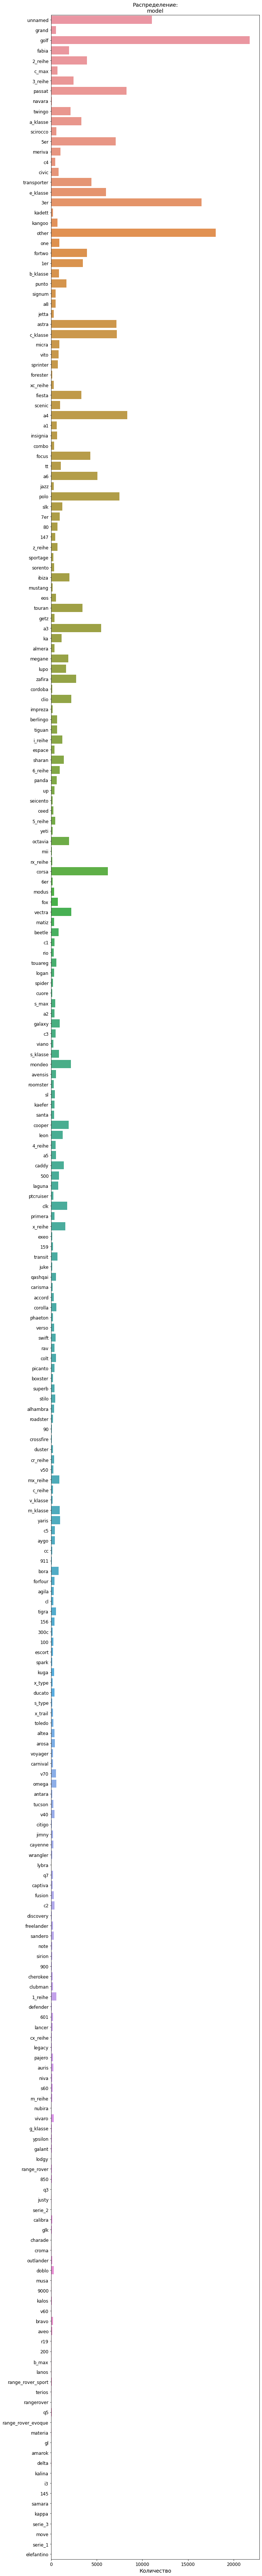

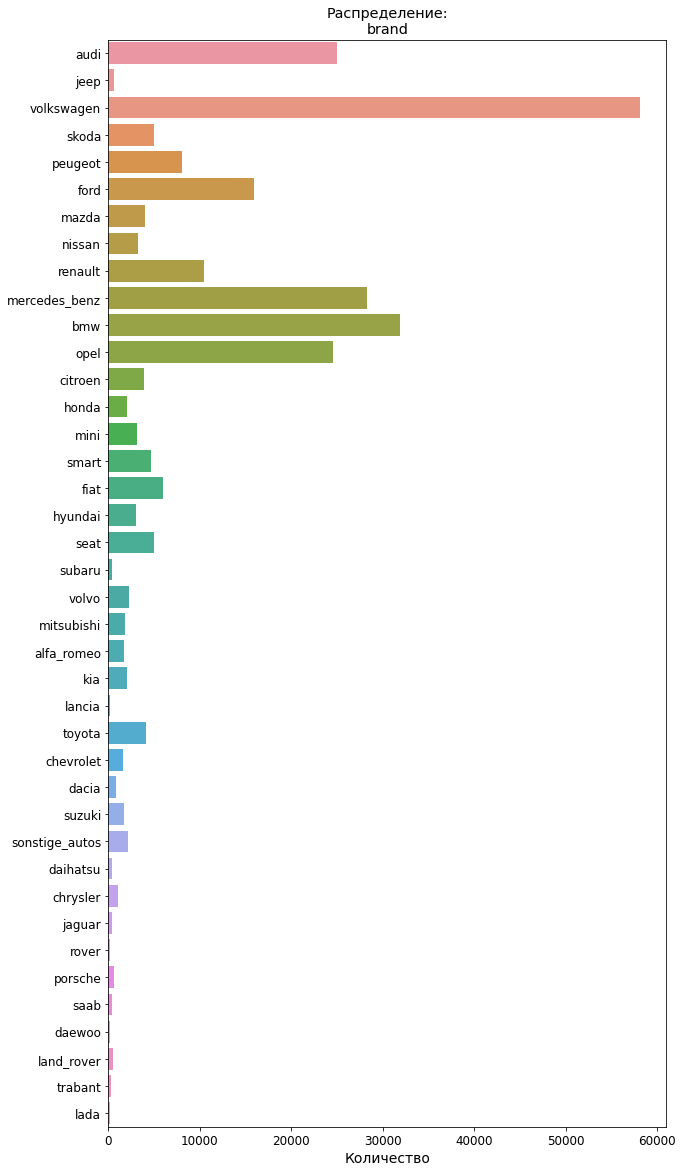

In [29]:
display('Категориальные признаки')
plot_bar(cat)

По графикам видно, что показатель года регистрации автомобилей имеет аномальные значения. Удалим значения ниже 1900 года и выше 2020 года.

In [30]:
display(df[df['registration_year'] > 2020]['registration_year'].count())
display(df[df['registration_year'] < 1900]['registration_year'].count())

42

15

**Исключение аномалий**

In [31]:
df = df.query('1900 < registration_year < 2020')

**Проверка изменений**

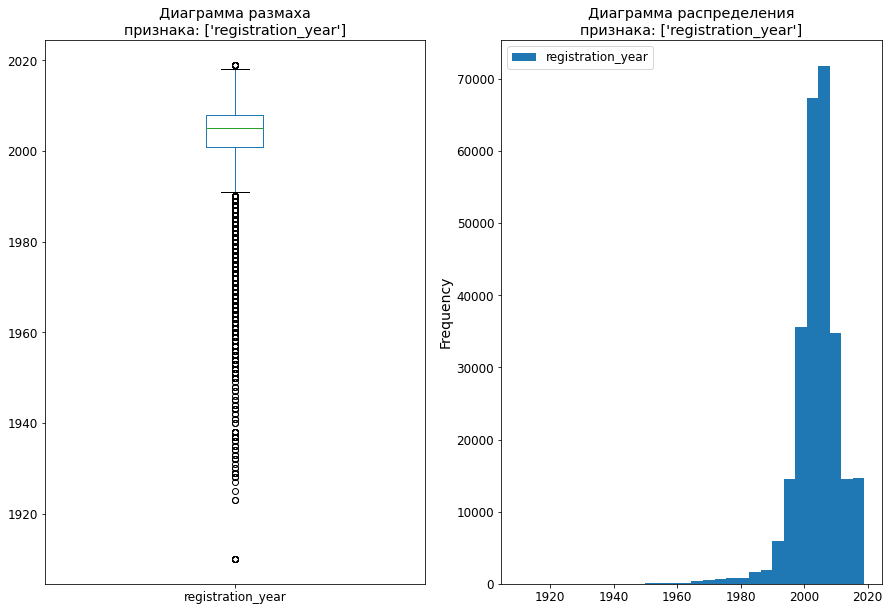

<Figure size 720x720 with 0 Axes>

In [32]:
plot_box(['registration_year']);

Измнения применены успешно

***
Вывод:
- Данные соответствуют описанию;
- Исправлены наименования и формат столбцов;
- Удалены неинформативные признаки;
- Обработыны пропуски, дубликаты и аномалии.
***

## Обучение моделей

**Разделение выборок**

In [33]:
X = df.drop('price', axis=1)
y = df['price']

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE)

**Составление пайплайна**

In [35]:
preprocessor = ColumnTransformer(transformers=[
    ('ordinal_encoding',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), cat),
    ('col_scaling', StandardScaler(), col)
])

**Параметры для моделей**

In [36]:
params_lgbm = [
    {
        'models': [LGBMRegressor()],
        'models__n_estimators': [80, 100, 120],
        'models__max_depth': [10, 15, 20],
        'models__boosting_type': ['gbdt', 'dart', 'rf'],
        'prep__col_scaling': [StandardScaler(),
                               RobustScaler(),
                               'passthrough']
    }]

params_tree = [{
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(18, 20),
        'models__min_samples_leaf': range(2, 4),
        'models__min_samples_split': range(2, 5),
        'prep__col_scaling': [StandardScaler(),
                                   RobustScaler(), 
                                   'passthrough']  
    }
]

**Основной пайплайн**

In [37]:
pipe_lgbm = Pipeline(steps=[
        ('prep', preprocessor),
        ('models', LGBMRegressor())
])
pipe_tree = Pipeline(steps=[
        ('prep', preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [38]:
grid_lgbm = GridSearchCV(
    pipe_lgbm,
    param_grid=params_lgbm,
    cv=5, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1)

grid_tree = GridSearchCV(
    pipe_tree,
    param_grid=params_tree,
    cv=5, 
    scoring='neg_root_mean_squared_error',
    n_jobs=-1)

**Поиск лучших параметров**

In [39]:
%%time
grid_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 127839, number of used features: 6
[LightGBM] [Info] Start training from score 5700.373415
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 127839, number of used features: 6
[LightGBM] [Info] Start training from score 5694.941559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Fatal] Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 390
[LightGBM] [Info] Number of data points in the train set: 159799, number of used features: 6
[LightGBM] [Info] Start training from score 5702.771331
CPU times: user 12min 29s, sys: 3.31 s, total: 12min 32s
Wall time: 12min 34s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('ordinal_encoding',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=nan),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'model',
                                                                          'brand']),
                                                                        ('col_scaling',
                                                                         StandardScaler(),
                                                                         ['registration_year',
                                                                          'kilometer'])])),
                                       ('models', LGBMRegressor())]),
             n_jobs=-1,
             param_grid=[{'models': [LGBMRegressor()],
                          'models__boosting_type': ['gbdt', 'dart', 'rf'],
                          'models__max_depth': [10, 15, 20],
                          'models__n_estimators': [80, 100, 120],
                          'prep__col_scaling': [StandardScaler(),
                                                RobustScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

In [40]:
%%time
grid_tree.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


CPU times: user 4min 24s, sys: 1min 21s, total: 5min 46s
Wall time: 5min 46s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('ordinal_encoding',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=nan),
                                                                         ['vehicle_type',
                                                                          'gearbox',
                                                                          'model',
                                                                          'brand']),
                                                                        ('col_scaling',
                                                                         StandardScaler(),
                                                                         ['registration_year',
                                                                          'kilometer'])])),
                                       ('models',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeClassifier(random_state=42)],
                          'models__max_depth': range(18, 20),
                          'models__min_samples_leaf': range(2, 4),
                          'models__min_samples_split': range(2, 5),
                          'prep__col_scaling': [StandardScaler(),
                                                RobustScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error')

### Вывод:
- Построен пайплайн обучения для моделей
- Обучены две модели: Древо решений и LightGBM
- LightGBM имеет значительно более низкую скорость поиска лучших параметров.

***
## Анализ моделей

**Параметры модели LightGBM**

*Скорость обучения*

In [41]:
%%time
grid_lgbm.best_estimator_.fit(X_train, y_train);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 390
[LightGBM] [Info] Number of data points in the train set: 159799, number of used features: 6
[LightGBM] [Info] Start training from score 5702.771331
CPU times: user 1 s, sys: 7.67 ms, total: 1.01 s
Wall time: 1.02 s


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('ordinal_encoding',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'brand']),
                                                 ('col_scaling',
                                                  StandardScaler(),
                                                  ['registration_year',
                                                   'kilometer'])])),
                ('models', LGBMRegressor(max_depth=15, n_estimators=120))])

*Метрика RMSE*

In [42]:
round(- grid_lgbm.best_score_, 2)

2172.73

*Время предсказания*

In [43]:
%%time
grid_lgbm.best_estimator_.predict(X_valid);

CPU times: user 352 ms, sys: 3.7 ms, total: 356 ms
Wall time: 365 ms


array([ 2707.14676531,  5692.35521766,  2555.62768594, ...,
       12479.02754496,  3219.25024456, 10310.31091555])

**Параметры модели древа решений**

*Скорость обучения*

In [44]:
%%time
grid_tree.best_estimator_.fit(X_train, y_train);

CPU times: user 1.52 s, sys: 371 ms, total: 1.89 s
Wall time: 1.9 s


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('ordinal_encoding',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'brand']),
                                                 ('col_scaling',
                                                  StandardScaler(),
                                                  ['registration_year',
                                                   'kilometer'])])),
                ('models',
                 DecisionTreeClassifier(max_depth=18, min_samples_leaf=2,
                                        random_state=42))])

*Метрика RMSE*

In [45]:
round(- grid_tree.best_score_, 2)

2902.05

*Время предсказания*

In [46]:
%%time
grid_tree.best_estimator_.predict(X_valid);

CPU times: user 323 ms, sys: 200 ms, total: 522 ms
Wall time: 522 ms


array([ 1500,  4600,  1200, ..., 11000,  3800, 10900])

**Вывод**
- Скорость обучения:
    - LGBM = 1.02 с.
    - Древо решений = 1.9 с.
- Метрика RMSE:
    - LGBM = 2172.73
    - Древо решений = 2902.05
- Скорость предсказания:
    - LGBM = 0.365
    - Древо решений = 0.522 с
- Ансамбль LGBM превосходит по всем параметрам модель древа решений

**Тестирование лучшей модели**

In [47]:
result = root_mean_squared_error(grid_lgbm.best_estimator_.predict(X_test), y_test)
print(f'Оценка на тестовой выборке = {round(result, 2)}')

Оценка на тестовой выборке = 2159.55


**График важности факторов**

In [48]:
feature_names = cat
feature_names.extend(col)

<AxesSubplot:>

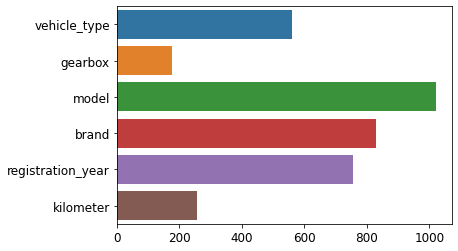

In [49]:
sns.barplot(x=grid_lgbm.best_estimator_['models'].feature_importances_, y=feature_names)

***
# Вывод

- Загружены, изучены и обработаны данные:
    - Дубликаты;
    - Пропуски;
    - Форматы данных;
    - Наименования столбцов;
    - Неинформативные признаки;
    - Аномалии.
- Обучены модели:
    - Древо решений;
    - LightGBM;
    - Для каждой модели подобраны лучший гиперпараметры
- Выполнен анализ моделей с лучшими параметрами
    - Скорость обучения:
        - LGBM = 1.02 с.
        - Древо решений = 1.9 с.
    - Метрика RMSE:
        - LGBM = 2172.73
        - Древо решений = 2902.05
    - Скорость предсказания:
        - LGBM = 0.365
        - Древо решений = 0.522 с
    - По всем параметрам ансамбль LGBM оказался значительно лучше, чем древо решений.
- Проведено тестирование лучшей модели
    - Метрика лучшей модели на тестовой выборке = 2159.55
- Построен график важности факторов